In [1]:
import numpy
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Flatten,Input,Lambda
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical,plot_model

from tqdm.notebook import tqdm

# dir
Base_dir = 'reso'

In [2]:
# image features extraction model
imageSize = [224,224]
model = VGG16()
model = Model(inputs=model.inputs,outputs=model.layers[-2].output) # leavinf out the pred layer
print(model.summary())

2022-06-27 13:47:19.934684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# all the images features are predected and saved in a .pkl file for safty
features ={}
directory = os.path.join(Base_dir,'Images')
# # --------------------------------------------------------------------------------------------------------this is too much time takking
# # print(os.listdir(directory))
# # for img_name in tqdm(os.listdir(directory)):
# for img_name in os.listdir(directory):
#     img_path = directory+'/'+img_name  # img path
#     img = load_img(img_path,target_size=imageSize) #img
#     img = np.array(img) # img --> numpy array
#     img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2]) # resizzing for the model
#     img = preprocess_input(img) # vgg preproc
#     feature = model.predict(img,verbose=2) # getting features
#     img_id = img_name.split('.')[0] # getting the id of the image
#     features[img_id] = feature # store features

# with open('features.pkl', 'wb') as file: # save the features from above
#     pickle.dump(features, file)
# # --------------------------------------------------------------------------------------------------------

# to load features
with open('features.pkl','rb') as f:
    features = pickle.load(f)

len(features)

8091

In [14]:
features['2387197355_237f6f41ee']

array([[0.87186486, 0.        , 0.        , ..., 0.30542886, 0.        ,
        2.0037658 ]], dtype=float32)

In [6]:
# all captions for the images are loaded here
with open(os.path.join(Base_dir,'captions.txt'),'r') as f:
    next(f)
    captions_doc = f.read()

len(captions_doc)

3319280

In [32]:
# mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',') # img, id --> line format
    if len(line)<2: # for errors
        continue
    img_id, caption = tokens[0],tokens[1:]
    img_id = img_id.split('.')[0]
    caption = " ".join(caption)
    if img_id not in mapping:
        mapping[img_id]=[]
    mapping[img_id].append(caption)

# saving one for safty
# with open('mapping.pkl', 'wb') as file: # save the mapping from above
#     pickle.dump(mapping, file)
# mapping
     
print(len(mapping))

#cleaninf the text data
def clean(mapping):
    for im,cap_s in mapping.items():
        for i in range(len(cap_s)):
            cap = cap_s[i]
            cap=cap.lower()
            cap=cap.replace('[^A-Za-z]','') #removings waste units
            cap=cap.replace('\s+',' ') # removinfg sapce
            cap = 'start_seq ' + " ".join([word for word in cap.split() if len(word)>1]) + ' end_seq' # for the start and end tag && removing the worlds like "a" and others
            cap_s[i] = cap

print('before clean :\n',mapping['1000268201_693b08cb0e']) # mapping.keys() # 1000268201_693b08cb0e
clean(mapping)
print('after clean :\n',mapping['1000268201_693b08cb0e'])

  0%|          | 0/40456 [00:00<?, ?it/s]

8091
before clean :
 ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
after clean :
 ['start_seq child in pink dress is climbing up set of stairs in an entry way end_seq', 'start_seq girl going into wooden building end_seq', 'start_seq little girl climbing into wooden playhouse end_seq', 'start_seq little girl climbing the stairs to her playhouse end_seq', 'start_seq little girl in pink dress going into wooden cabin end_seq']


In [33]:
# LSTM

# tokenizer
all_caption=[]
for key in mapping:
    for caption in mapping[key]:
        all_caption.append(caption)

# tokenizing teh text

toki = Tokenizer()
toki.fit_on_texts(all_caption)

# para
vocab_size=len(toki.word_index)+1 # for the iput to the nn
max_length= 5  # --> max legth fir padding
for i in all_caption:
    max_length=max(len(i.split()),max_length)
# max_length

In [34]:
# list(mapping.keys())
image_ids = list(mapping.keys())
split_num = int(len(image_ids)*0.90)
train = image_ids[:split_num]
test = image_ids[split_num:]
len(train)

7281

In [1]:
# # train test split
# from sklearn.model_selection import train_test_split
# img_train,cap_train,img_test,cap_test=train_test_split(img_id,captions_doc,text_size=0.2,random_state=101)

In [35]:
# since only 16gm ram is there we are doing this

# data gen
# <start>seq girl going into wooden building endseq
#        X                   y
# <start>seq                   girl
# <start>seq girl              going
# <start>seq girl going        into

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0] 
                    # encode output sequence --> one hot encoding
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0]) # imag features 
                    X2.append(in_seq) # the start word , the given avove
                    y.append(out_seq) # the contin of the above sentence
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y # basically returs the the collected samples ti the generators
                X1, X2, y = list(), list(), list() # re intililizing the memory (this was the wohole issue to do it like this)
                n = 0

# model will consume these inputs 

In [36]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# model
# encoder model
# image feature layers
# since we extratxcted teh features above we dont gave to put them here, we will be directly use the features
inputs1 = Input(shape=(4096,)) # this is what we get from the vgg model, from top we can put this value
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2) 

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [22]:
# train

epochs = 15
# epochs = 20
batch_size = 32
# batch_size = 64
steps = len(train)//batch_size 

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, toki, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 515s 2s/step - loss: 2.3531


In [23]:
model.save('best_mod.h5')

/Users/rohitreddypanyam/opt/anaconda3/envs/ML/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [25]:
# helper funtion
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
    

In [26]:
# get the dsrc for the img
def predDscr(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start_seq'
    for i in range(max_length): # iterate over the max length of sequence

        # sequence 
        sequence = tokenizer.texts_to_sequences([in_text])[0] # encode input sequence
        sequence = pad_sequences([sequence], max_length) # pad the sequence

        # getting the words(ins the strip)
        yhat = model.predict([image, sequence], verbose=0) # predict next word
        yhat = np.argmax(yhat) # get index with high probability
        word = idx_to_word(yhat, tokenizer) # convert index to word
        if word is None: # stop if word not found
            break
        in_text += " " + word  # append word as input for getting next word
        if word == 'end_seq': # stop at end tag
            break
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predDscr(model, features[key], toki, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

/Users/rohitreddypanyam/opt/anaconda3/envs/ML/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/rohitreddypanyam/opt/anaconda3/envs/ML/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.194444
BLEU-2: 0.105409
BLEU-1: 0.166667
BLEU-2: 0.109109
BLEU-1: 0.129630
BLEU-2: 0.078567
BLEU-1: 0.125000
BLEU-2: 0.066815
BLEU-1: 0.116667
BLEU-2: 0.057735
BLEU-1: 0.125000
BLEU-2: 0.059761
BLEU-1: 0.130952
BLEU-2: 0.069358
BLEU-1: 0.135417
BLEU-2: 0.072938
BLEU-1: 0.135802
BLEU-2: 0.071927
BLEU-1: 0.136111
BLEU-2: 0.071102
BLEU-1: 0.138889
BLEU-2: 0.068482
BLEU-1: 0.141204
BLEU-2: 0.071014
BLEU-1: 0.149573
BLEU-2: 0.072524
BLEU-1: 0.148810
BLEU-2: 0.071852
BLEU-1: 0.144444
BLEU-2: 0.070373
BLEU-1: 0.138889
BLEU-2: 0.066815
BLEU-1: 0.145425
BLEU-2: 0.069916
BLEU-1: 0.145062
BLEU-2: 0.072773
BLEU-1: 0.146199
BLEU-2: 0.072638
BLEU-1: 0.144444
BLEU-2: 0.073247
BLEU-1: 0.146825
BLEU-2: 0.073441
BLEU-1: 0.145202
BLEU-2: 0.073950
BLEU-1: 0.146135
BLEU-2: 0.075017
BLEU-1: 0.143519
BLEU-2: 0.072777
BLEU-1: 0.144444
BLEU-2: 0.074918
BLEU-1: 0.144231
BLEU-2: 0.076579
BLEU-1: 0.146091
BLEU-2: 0.078637
BLEU-1: 0.146825
BLEU-2: 0.081192
BLEU-1: 0.147510
BLEU-2: 0.081763
BLEU-1: 0.1481

In [30]:
# from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predDscr(model, features[image_id], toki, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
start_seq group of people are sitting around campfire at night end_seq
start_seq group of people sitting on the grass by fire at nighttime end_seq
start_seq group of young people are sitting around fire pit end_seq
start_seq friends enjoy campfire end_seq
start_seq several people sitting around campfire end_seq
--------------------Predicted--------------------
<start> yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht yacht


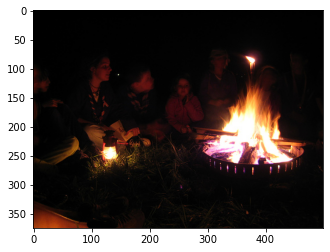

In [38]:
generate_caption("69710411_2cf537f61f.jpg")